## Convolution Neural Network (CNN)
In this notebook we show how to do the classification using a simple CNN. First we load the data and the necessary libraries. As in the previous notebook we could also load the whole data set.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import cPickle as pickle
import gzip
with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

((4000, 1, 28, 28), (4000,), 28)

In [5]:
#from create_mnist import load_data_2d
#X,y,PIXELS = load_data_2d('/home/dueo/dl-playground/data/mnist.pkl.gz')
#X.shape, y

X contains the images and y contains the labels.

### A first simple CNN
Now let's train a network using the loaded data. First we have to design the architecture of the network.
#### Definition of the network
We again use the simple definition using the class `NeuralNet` from `nolearn.lasagne` to create a network like this 

<img src="imgs/lenet.png" width="700"/>

In [2]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    hidden4_num_units=500,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=10,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

####Training of the net. 
As in the MLP example the data is split automatically into 80% training set and 20% test set. Since it takes quite a while to finish an epoch (at least with a CPU), we reduce the data to 1000 samples (800 for training and 200 for testing). Note also that the geometry makes sense. The first 3x3 convolution knocks off 2 pixels from the 28x28 images resulting in 26x26 images. Then the maxpooling with size 2x2 reduces these images to 13x13 pixels... 

In [3]:
net = net1.fit(X[0:1000,:,:,:],y[0:1000])

  DenseLayer        	(None, 10)          	produces      10 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    2.209664  |    1.983545  |     1.113998  |     52.32%  |  7.0s
     2  |    1.702469  |    1.365793  |     1.246505  |     65.03%  |  7.0s
     3  |    1.008289  |    0.821318  |     1.227647  |     77.47%  |  6.9s
     4  |    0.603863  |    0.681294  |     0.886347  |     79.03%  |  6.9s
     5  |    0.410593  |    0.666037  |     0.616472  |     80.35%  |  6.9

/Library/Python/2.7/site-packages/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/Library/Python/2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
/Library/Python/2.7/site-packages/lasagne/layers/base.py:99: UserWarning: layer.get_output_shape() is deprecated and will be removed for the first release of Lasagne. Please us

Note this takes a bit time on a CPU (approx 7 sec) for each epoch. If running on the GPU it onlty takes about 0.2 sec for each epoch.

We have a trained classifier with which we can make predictions.

In [4]:
net.predict(X[3000:3010,:,:,:])

array([9, 0, 9, 8, 1, 3, 2, 5, 7, 4])

**That's basically all we need! ** We can make predictions on new data.
In the following I will show you how to store and reload the learned model. The reloaded model can then be further trained.

##### Storing the trained model
We now store the trained model using the pickle mechanism as follows:

In [5]:
import cPickle as pickle
with open('data/net1.pickle', 'wb') as f:
    pickle.dump(net, f, -1)

In [98]:
%ls -rtlh data

ls: data: No such file or directory


#### Loading a stored model
We load the model trained model again...

In [6]:
import cPickle as pickle
with open('data/net1.pickle', 'rb') as f:
    net_pretrain = pickle.load(f)

#### Training further (more iterations)
We can now take the net and train it for further iterations. We will see that the training loss already starts with the low value from the previous model. So the model is really reloaded.

In [7]:
net_pretrain.fit(X[0:1000,:,:,:],y[0:1000]);

  DenseLayer        	(None, 10)          	produces      10 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.124337  |    0.522876  |     0.237795  |     87.17%  |  7.1s
     2  |    0.113882  |    0.532682  |     0.213790  |     87.44%  |  6.9s
     3  |    0.097049  |    0.533600  |     0.181877  |     87.44%  |  6.9s
     4  |    0.082564  |    0.534813  |     0.154380  |     87.44%  |  6.8s
     5  |    0.069916  |    0.538397  |     0.129861  |     87.44%  |  6.8

#### Training further (new data)
We can train also on new data. Now for 5 epochs...

In [8]:
net_pretrain.max_epochs = 5
net_pretrain.fit(X[1000:2000,:,:,:],y[1000:2000]);

  DenseLayer        	(None, 10)          	produces      10 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.522029  |    1.349795  |     0.386747  |     75.89%  |  6.9s
     2  |    0.281187  |    0.891798  |     0.315304  |     81.61%  |  6.8s
     3  |    0.196492  |    0.872268  |     0.225265  |     82.62%  |  6.8s
     4  |    0.122728  |    0.852510  |     0.143960  |     81.84%  |  6.8s
     5  |    0.085803  |    0.837496  |     0.102452  |     82.23%  |  6.9

### Evaluate the model
We now make predictions on unseen data. We have trained only on the images 0-1999.

In [9]:
toTest = range(3001,3026)
preds = net1.predict(X[toTest,:,:,:])
preds

array([0, 9, 8, 1, 3, 2, 5, 7, 4, 9, 8, 6, 3, 9, 0, 6, 2, 4, 1, 9, 3, 9, 2,
       0, 5])

Let's look at the correponding images.

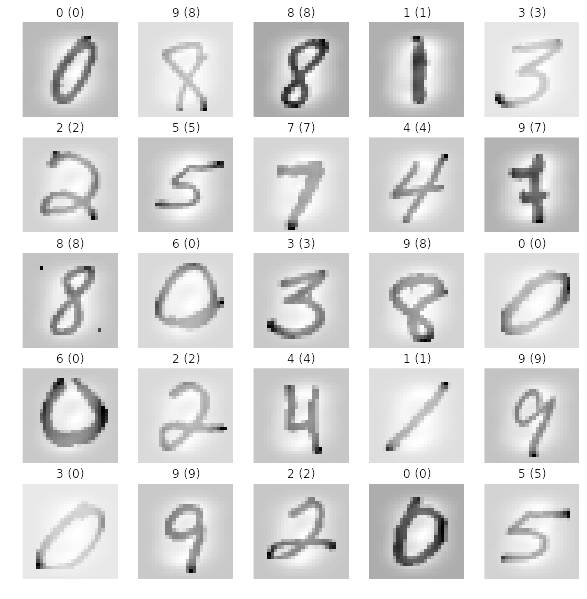

In [10]:
fig = plt.figure(figsize=(10,10))
for i,num in enumerate(toTest):
    a=fig.add_subplot(5,5,(i+1)) #NB the one based API sucks!
    plt.axis('off')
    a.set_title(str(preds[i]) + " (" + str(y[num]) + ")")
    plt.imshow(-X[num,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))

## Miscelaneous 

### Accessing the weights of the network
To caluclate the number of weights in the networks, we have to take the following layers into account:

1. First Convolutional Layer: 32x3x3 + 32 = 320(32 filter and 32 biases)
2. Second Convolutional Layer: This layer goes from 32 to 64 using 32*64 = 2048 Kernels of size 2x2. So Altogether: 32x64x2x2 + 64 = 8256 weights are used.
3. Fully connected layer (hidden4): The fully connected layers contains 500 nodes with connect to the 64 6x6 images for the last pooling layer. Hence, we have 500 x 6 x 6 x 64 + 500 = 1152500 weights
4. Output layer: The 500 nodes of hidden4 are the fully connected to the 10 outnodes reflecting the 10 classes. Together with the bias, we have 5010 weights.

So altogether for this toy model we already have about 1.2 Million parameters, much less then we have examples. A nightmare in classical statistic. Modern architectures like "Oxford Net" have more than 100 Million parameter. The weights can be obtained as follows (the biases are given in the one dimensional terms).

In [12]:
import operator
import numpy as np
weights = [w.get_value() for w in net.get_all_params()]
numParas = 0
for i, weight in enumerate(weights):
    n = reduce(operator.mul, np.shape(weight))
    print(str(i), " ", str(np.shape(weight)), str(n))  
    numParas += n
print("Number of parameters " + str(numParas))


('0', ' ', '(10,)', '10')
('1', ' ', '(500, 10)', '5000')
('2', ' ', '(500,)', '500')
('3', ' ', '(2304, 500)', '1152000')
('4', ' ', '(64,)', '64')
('5', ' ', '(64, 32, 2, 2)', '8192')
('6', ' ', '(32,)', '32')
('7', ' ', '(32, 1, 3, 3)', '288')
Number of parameters 1166086


### Visualizing the weights

The 32 3x3 weight of the convolutional layer can be visualized as follows.

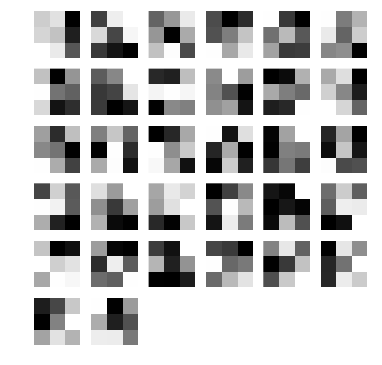

In [13]:
conv = net.get_all_params()

ws = conv[7].get_value() #Use the layernumber for the '(32, 1, 3, 3)', '288' layer from above
fig = plt.figure(figsize=(6,6))
for i in range(0,32):
    a=fig.add_subplot(6,6,(i+1))#NB the one based API sucks! 
    plt.axis('off')
    plt.imshow(ws[i,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))